In [1]:
import psycopg2
import pandas as pd
from pandas_profiling import ProfileReport
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

%matplotlib inline
load_dotenv()

In [11]:
conn = psycopg2.connect(database="juan-database",
                        host="34.132.75.146",
                        user="postgres",
                        password=os.environ.get('PASSWORD'),
                        port="5432")
query = """ SELECT * 
            FROM public.fraudes
        """
        
fraud_data = pd.read_sql(query, conn)
fraud_data.head()

/Users/juan/opt/anaconda3/envs/pycaret/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,monthh,weekofmonth,dayofweek,make,accidentarea,dayofweekclaimed,monthclaimed,weekofmonthclaimed,sex,maritalstatus,...,ageofvehicle,ageofpolicyholder,policereportfiled,witnesspresent,agenttype,numberofsuppliments,addresschange_claim,numberofcars,yearr,basepolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


# Exploratory Data Analysis

In [8]:
profile = ProfileReport(fraud_data, title='Fraud Report', minimal=True, explorative = True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

After checking the report generated by PandasProfiling, the following remarks can be noted:
- There are no empty cells, meaning that every field of the table has all of its values as non-null. <br><br>
- The target field, which is FraudFound_P is imbalanced. The value of 0 has a frequency of more than 90%, whereas the value of 1 has less than 10%. Therefore, an oversampling or undersampling method, or a combination of both should be used to handle this situaiton. <br><br>
- Most of the fields are categorical and only 9 of them are numeric, including date related fields.  <br><br>
- Some categorical fields have no diversification in the frequency of their values, making them bad candidates to be used as input variables for the model.

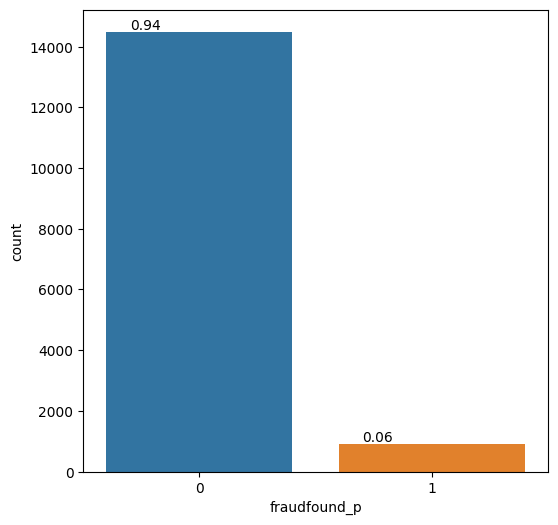

In [25]:
# Target field imbalance check
fig, ax = plt.subplots(figsize=(6,6))
ax = sns.countplot(x='fraudfound_p',data=fraud_data)
for p in ax.patches:
  ax.annotate('{}'.format(round(p.get_height()/len(fraud_data),2)), (p.get_x()+0.1, p.get_height()+50))

/var/folders/gf/f4q1wqb55gl_fdvvz87h72bw0000gn/T/ipykernel_62841/1282306643.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrMatrix = fraud_data.corr()


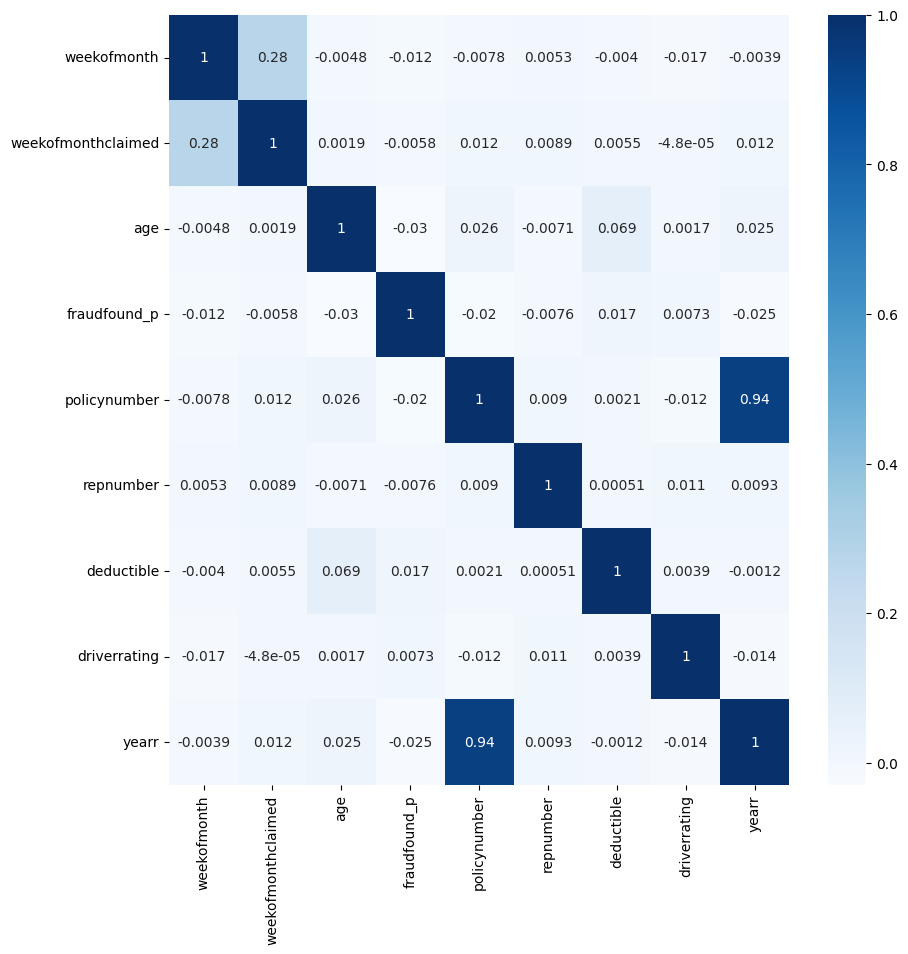

In [26]:
# Pearson's correlation matrix
corrMatrix = fraud_data.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corrMatrix, annot=True, cmap='Blues')
plt.show()

Taking into account the results from the PandasProfiling report, the correlation matrix and the nature of the fields themself, the columns that will be used as input variables for the predictive model are:

- **Categorical:**
  - make
  - accidentarea
  - maritalstatus
  - fault
  - policytype
  - agenttype
  - numberofsuppliments
  - numberofcars
  - vehicleprice
  - ageofvehicle
  - ageofpolicyholder
<br><br>
- **Numeric:**
  - deductible

# Binary Classification Model

Since the target variable is binary, which means that it only takes two possible values, 0 or 1, the machine learning model that needs to be built to predict is a Binary Classification Model. In this case Pycaret will be used to train the model and make predictions. [**Pycaret**](https://pycaret.org/) is an open-source, low-code machine learning library in Python that automates machine learning workflows.

In [24]:
from pycaret.classification import *
from imblearn.combine import SMOTEENN
import pickle
import skopt

In [23]:
query = """ SELECT 
            policynumber AS id,
            accidentarea AS accident_area,
            maritalstatus AS marital_status,
            policytype AS policy_type,
            agenttype AS agent_type,
            numberofsuppliments AS number_of_suppliments,
            numberofcars AS number_of_cars,
            vehicleprice AS vehicle_price,
            ageofvehicle AS age_of_vehicle,
            ageofpolicyholder AS age_of_policy_holder,
            fault AS fault,
            make AS make,
            deductible AS deductible,
            fraudfound_p AS fraud
            FROM public.fraudes
        """
        
fraud_data = pd.read_sql(query, conn)
fraud_data.head()

/Users/juan/opt/anaconda3/envs/pycaret/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,id,accident_area,marital_status,policy_type,agent_type,number_of_suppliments,number_of_cars,vehicle_price,age_of_vehicle,age_of_policy_holder,fault,make,deductible,fraud
0,1,Urban,Single,Sport - Liability,External,none,3 to 4,more than 69000,3 years,26 to 30,Policy Holder,Honda,300,0
1,2,Urban,Single,Sport - Collision,External,none,1 vehicle,more than 69000,6 years,31 to 35,Policy Holder,Honda,400,0
2,3,Urban,Married,Sport - Collision,External,none,1 vehicle,more than 69000,7 years,41 to 50,Policy Holder,Honda,400,0
3,4,Rural,Married,Sedan - Liability,External,more than 5,1 vehicle,20000 to 29000,more than 7,51 to 65,Third Party,Toyota,400,0
4,5,Urban,Single,Sport - Collision,External,none,1 vehicle,more than 69000,5 years,31 to 35,Third Party,Honda,400,0


Before training the model, a randon sample of the data is extracted to be used later to make predictions and validate how well the model performs.

In [39]:
print("Getting unseen data for validation")
data = fraud_data.sample(frac=0.95, random_state=785)
data_unseen = fraud_data.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions ' + str(data_unseen.shape))

Getting unseen data for validation
Data for Modeling: (14649, 14)
Unseen Data For Predictions (771, 14)


Now the *setup* function is used to initialize the experiment in PyCaret and create the transformation pipeline based on all the parameters passed in the function.

In [22]:
print("Setting up Pycaret experiment")
sme = SMOTEENN(random_state=42, n_jobs=-1) # The chosen method to fix imbalance is SMOTEENN
s = setup(data = data, 
          session_id=123,
          remove_outliers = True, 
          outliers_threshold = 0.05,
          normalize = True, 
          transformation = True, 
          combine_rare_levels = True,
          ignore_low_variance = True,
          remove_multicollinearity = True, 
          multicollinearity_threshold = 0.7,
          data_split_stratify = True,
          fix_imbalance=True,
          fix_imbalance_method = sme,
          high_cardinality_features = ['make'],
          high_cardinality_method = 'frequency',
          target = 'fraud',
          ignore_features = ['id'],
          categorical_features = ['accident_area','marital_status','fault',
                                  'policy_type','agent_type','number_of_suppliments',
                                  'number_of_cars','vehicle_price','age_of_vehicle',
                                  'age_of_policy_holder'],
          numeric_features = ['deductible'],
          silent = False)

,Description,Value
0,session_id,123
1,Target,fraud
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(14649, 14)"
5,Missing Values,False
6,Numeric Features,1
7,Categorical Features,11
8,Ordinal Features,False
9,High Cardinality Features,True


Let's compare the models available in Pycaret, sorted by their performance with the AUC metric, then tune the hyperparameters of the best one and finally printing its metrics.

In [54]:
print("Getting bests models trained")
best_models = compare_models(cross_validation=False, n_select = 5, sort = 'AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8978,0.7904,0.2490,0.2044,0.2245,0.1704,0.1714,1.8900
lr,Logistic Regression,0.6207,0.7819,0.8851,0.1237,0.2170,0.1259,0.2338,2.0600
lda,Linear Discriminant Analysis,0.6041,0.7808,0.9004,0.1206,0.2127,0.1206,0.2311,1.6200
gbc,Gradient Boosting Classifier,0.7841,0.7794,0.5172,0.1409,0.2215,0.1413,0.1821,3.3500
ada,Ada Boost Classifier,0.7133,0.7779,0.6820,0.1314,0.2203,0.1341,0.2033,2.0000
xgboost,Extreme Gradient Boosting,0.8937,0.7746,0.2107,0.1741,0.1906,0.1343,0.1350,5.0700
nb,Naive Bayes,0.6480,0.7570,0.7088,0.1117,0.1930,0.1007,0.1722,1.4700
svm,SVM - Linear Kernel,0.5941,0.7501,0.9272,0.1206,0.2134,0.1210,0.2374,1.5800
ridge,Ridge Classifier,0.6036,0.7480,0.9119,0.1216,0.2146,0.1227,0.2359,1.5400
rf,Random Forest Classifier,0.8639,0.7183,0.3027,0.1596,0.2090,0.1423,0.1511,2.5300


Taking into account the context of the business which is fraud detection and the fact that the target field is imbalanced, the selection of the best models is made according to the combination of AUC and Recall metrics. Therefore, the best possible models are:
- Logistic Regression
- Linear Discriminant Analysis
- SVM - Linear Kernel
- Ridge Classifier

To continue the ML workflow the Logistic Regresion model will be used as the chosen model.

In [59]:
best_models[1]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [57]:
print("Tunning hyperparameters for best model")
lr_model = best_models[1]
tuned_best_model = tune_model(lr_model, n_iter = 10, fold = 10, optimize = 'AUC', search_library = "scikit-optimize", search_algorithm = "bayesian", choose_better = True)

print("Metrics for the best model")
model_metrics = pull()
metrics = model_metrics.loc['Mean']
print(model_metrics.loc['Mean'])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6076,0.8074,0.8947,0.1192,0.2103,0.1196,0.2290
1,0.6096,0.7716,0.9138,0.1235,0.2177,0.1262,0.2402
2,0.6158,0.7757,0.8966,0.1235,0.2171,0.1258,0.2361
3,0.6219,0.7999,0.9310,0.1289,0.2264,0.1362,0.2548
4,0.6055,0.7446,0.8448,0.1153,0.2029,0.1098,0.2075
5,0.6209,0.7836,0.9310,0.1286,0.2259,0.1357,0.2542
6,0.6363,0.7983,0.9138,0.1315,0.2299,0.1406,0.2557
7,0.6076,0.7855,0.8103,0.1122,0.1971,0.1035,0.1935
8,0.6557,0.7429,0.8276,0.1283,0.2222,0.1330,0.2298


Metrics for the best model
Accuracy    0.6214
AUC         0.7847
Recall      0.8912
Prec.       0.1245
F1          0.2185
Kappa       0.1277
MCC         0.2370
Name: Mean, dtype: float64


After tunning the hyperparameters of the Logistic Regression model we get an average AUC of 0.78 and an average Recall of 0.89. 
Now let's predict over the unseen data that was extracted before to validate the model.

In [58]:
print("Predicting unseen data for validation")
predictions = predict_model(tuned_best_model, data=data_unseen, raw_score=True)

Predicting unseen data for validation


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.6394,0.8132,0.8889,0.1500,0.2567,0.1555,0.2639


Finally, let's save the model and the transformation pipeline.

In [60]:
print('Saving Model')
with open('./models/model.pkl','wb') as f:
  f.write(pickle.dumps(tuned_best_model))

print('Saving Preprocessing Pipeline')
save_config('./models/model_setup.pkl')

Saving Model
Transformation Pipeline and Model Successfully Saved
Saving Preprocessing Pipeline
